# Discover and Visualise the Data

## Import Libraries

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams


from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import MultilayerPerceptronClassifier
from sklearn.metrics import confusion_matrix, classification_report

/home/hduser/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Functions definition 

### Read in file

In [2]:
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items
train_df = pd.read_csv('training-set.csv')
test_df = pd.read_csv('testing-set.csv')

In [3]:
spark = SparkSession.builder.appName('IDS').getOrCreate()


24/04/06 17:14:39 WARN Utils: Your hostname, BDS-2023 resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/04/06 17:14:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/06 17:14:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark_df = spark.createDataFrame(train_df)
spark_df.show()

24/04/06 17:15:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/04/06 17:15:37 WARN TaskSetManager: Stage 0 contains a task of very large size (1417 KiB). The maximum recommended task size is 1000 KiB.


+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+----------+-----+
| id|   dur|proto|service|state|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|        sload|dload|sloss|dloss|   sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|attack_cat|label|
+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+--

#### Custom pipeline for data pre-processing

In [5]:
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = 'Binary'):
        self.label_encode = label_encode
        self.process_label = process_label
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state', 'attack_cat']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label == 'Binary':
            df.drop('attack_cat', axis=1, inplace=True)
        else:             
            df['attack_cat'], df['label'] = df['label'], df['attack_cat']
            df.drop('attack_cat', axis=1, inplace=True)      

        return df

#### Dataframe Pipeline

In [6]:
class SparkDFPipeline:
    def __init__(self, standardize=False):
        self.standardize = standardize
    
    def fit(self):
        return self
    
    def transform(self, train_df, test_df):      
        if self.standardize:
            # Standardize the df

            # Resample the df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)

            exclude = ['proto', 'service', 'state']
            input_columns = train_df.columns[:-1]
            selected_columns = [col for col in input_columns if col not in exclude]
            # Vectorize the df
            assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)

            # Standardize the df
            scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
            scaler_model = scaler.fit(train_df)
            train_df = scaler_model.transform(train_df)

            scaler_model = scaler.fit(test_df)
            test_df = scaler_model.transform(test_df)
            test_df = test_df.drop('features')
            train_df = train_df.drop('features')
            
            # put back the categorical columns
            input_cols = ['scaled_features', 'proto', 'service', 'state']
            output_col = "features"
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol=output_col)
            train_df = assembler1.transform(train_df)
            test_df = assembler1.transform(test_df)

            # return result
            test_df = test_df.select('features', 'label')
            train_df = train_df.select('features', 'label')
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)
            input_columns = train_df.columns[:-1]
            assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            train_df = train_df.select('features', 'label')
            test_df = assembler.transform(test_df)
              
        return train_df, test_df

#### For Logistic Regression

In [7]:
def train_weighted_logistic_regression(train_df):
    # Calculate class frequencies
    class_frequencies = train_df.groupBy("label").count()

    # Calculate class weights
    total_samples = train_df.count()
    class_frequencies = class_frequencies.withColumn("weight", total_samples / (class_frequencies["count"] * class_frequencies.count()))

    # Join the weights with the training data
    train_with_weights = train_df.join(class_frequencies, on="label")

    # Add a constant column for weight if it doesn't exist
    if "weight" not in train_with_weights.columns:
        train_with_weights = train_with_weights.withColumn("weight", lit(1.0))

    # Create a VectorAssembler
    assembler = VectorAssembler(inputCols=['features'], outputCol='assembled_features')

    # Define the Logistic Regression model with class weights
    lr_weighted = LogisticRegression(featuresCol='assembled_features', labelCol='label', maxIter=10, weightCol='weight')

    # Create a pipeline with the defined stages
    pipeline_weighted = Pipeline(stages=[assembler, lr_weighted])

    # Fit the pipeline on your training data with class weights
    model_weighted = pipeline_weighted.fit(train_with_weights)
    
    return model_weighted

#### For visualisation

In [8]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

#### For Evaluation

In [9]:
# Define your class labels
class_labels = ['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Analysis', 'Backdoor', 'Shellcode', 'Worms']

def evaluate_model(model, val_data, model_name, process_label):
    # Make predictions on the validation data
    predictions = model.transform(val_data)

    if process_label == 'Multi':
        acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        accuracy = acc_evaluator.evaluate(predictions)

        f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
        f1_score = f1_evaluator.evaluate(predictions)

        # AUC_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="areaUnderROC")
        # AUC_score = AUC_evaluator.evaluate(predictions)

        # AUPR_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="areaUnderPR")
        # AUPR_score = AUPR_evaluator.evaluate(predictions)

        precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
        precision_score = precision_evaluator.evaluate(predictions)

        recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
        recall_score = recall_evaluator.evaluate(predictions)
        
        # Convert Spark DataFrames to Pandas DataFrames for visualization
        y_true_pd = predictions.select('label').toPandas()
        y_pred_pd = predictions.select('prediction').toPandas()

        # Generate the confusion matrix
        cm = confusion_matrix(y_true_pd['label'], y_pred_pd['prediction'])

        # Get the predicted counts for each class label
        predicted_counts = y_pred_pd['prediction'].value_counts()

        # Create a dictionary to store the counts of each class label
        class_counts = {label: 0 for label in class_labels}

        # Fill in the dictionary with actual predicted counts where available
        for key, count in predicted_counts.items():
            class_counts[class_labels[int(key)]] = count

        # Convert the dictionary values to a list
        predicted_counts_list = [class_counts[label] for label in class_labels]

        # Display the confusion matrix as a heatmap with sorted class labels and counts
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels[::-1], yticklabels=class_labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(model_name)
        plt.show()


        # Create a dictionary of model evaluation metrics
        eval_metrics = {
            'Accuracy': accuracy
            , 'F1 Score': f1_score
            # , 'Area Under ROC': AUC_score
            # , 'Area Under PR': AUPR_score
            , 'Precision': precision_score
            , 'Recall': recall_score
        }

    elif process_label == 'Binary':
        auc_evaluator = BinaryClassificationEvaluator(labelCol='label')
        auc = auc_evaluator.evaluate(predictions)

        # Calculate Area Under Precision-Recall Curve using BinaryClassificationEvaluator
        pr_evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
        area_under_pr = pr_evaluator.evaluate(predictions)

        # Calculate True Positives, True Negatives, False Positives, and False Negatives
        tp = predictions.filter("label = 1 and prediction = 1").count()
        tn = predictions.filter("label = 0 and prediction = 0").count()
        fp = predictions.filter("label = 0 and prediction = 1").count()
        fn = predictions.filter("label = 1 and prediction = 0").count()

        # Calculate metrics using TP, TN, FP, FN
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        precision = tp / (tp + fp)
        recall = sensitivity
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        # youdens_j = sensitivity + specificity - 1
        # balanced_accuracy = (sensitivity + specificity) / 2

        # Convert Spark DataFrames to Pandas DataFrames for visualization
        confusion_matrix = pd.DataFrame({
            "Predicted 1": [tp, fp],
            "Predicted 0": [fn, tn]
        }, index=["Actual 1", "Actual 0"])

        # Plot the confusion matrix using Seaborn
        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.2)
        sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
        
        # Create a dictionary of model evaluation metrics
        eval_metrics = {
            'AUC': auc,
            'AreaUnderPR': area_under_pr,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1_score,
            'Accuracy': accuracy,
            # "Youden's J Index": youdens_j,
            # 'Balanced Accuracy': balanced_accuracy
        }

    return eval_metrics

## Data Exploration

### Explore train_df 

#### Change either 'Binary' or 'Multi' according to Classification use case

In [10]:
process_label = 'Binary'  # or 'Binary' depending on use case

if process_label == 'Multi':
    pipeline_train = PreProcessPipeline(label_encode=True, process_label='Multi')
    pipeline_test = PreProcessPipeline(label_encode=True, process_label='Multi')
elif process_label == 'Binary':
    pipeline_train = PreProcessPipeline(label_encode=True, process_label='Binary')
    pipeline_test = PreProcessPipeline(label_encode=True, process_label='Binary')

# Transform train and test data using the appropriate pipeline
train_df = pipeline_train.transform(train_df)
test_df = pipeline_test.transform(test_df)


## Data Visualisation

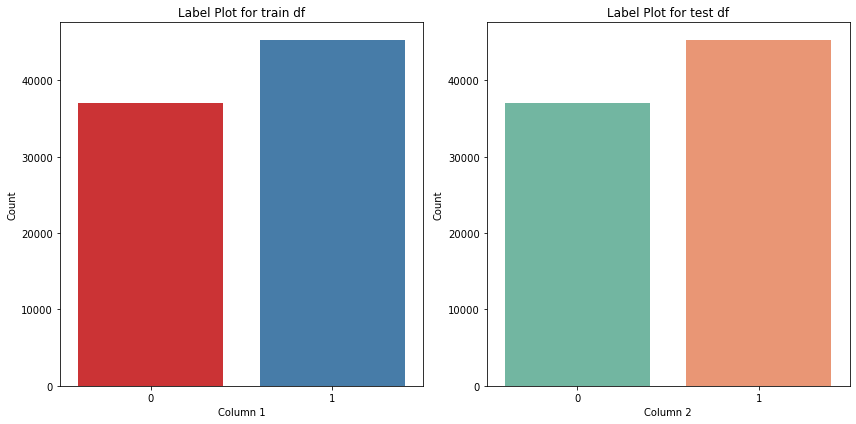

In [11]:
# Set up the figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot countplot for column1
sns.countplot(data=train_df, x='label', palette="Set1", ax=axes[0])
axes[0].set_title("Label Plot for train df")
axes[0].set_xlabel("Column 1")
axes[0].set_ylabel("Count")

# Plot countplot for column2
sns.countplot(data=test_df, x='label', palette="Set2", ax=axes[1])
axes[1].set_title("Label Plot for test df")
axes[1].set_xlabel("Column 2")
axes[1].set_ylabel("Count")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

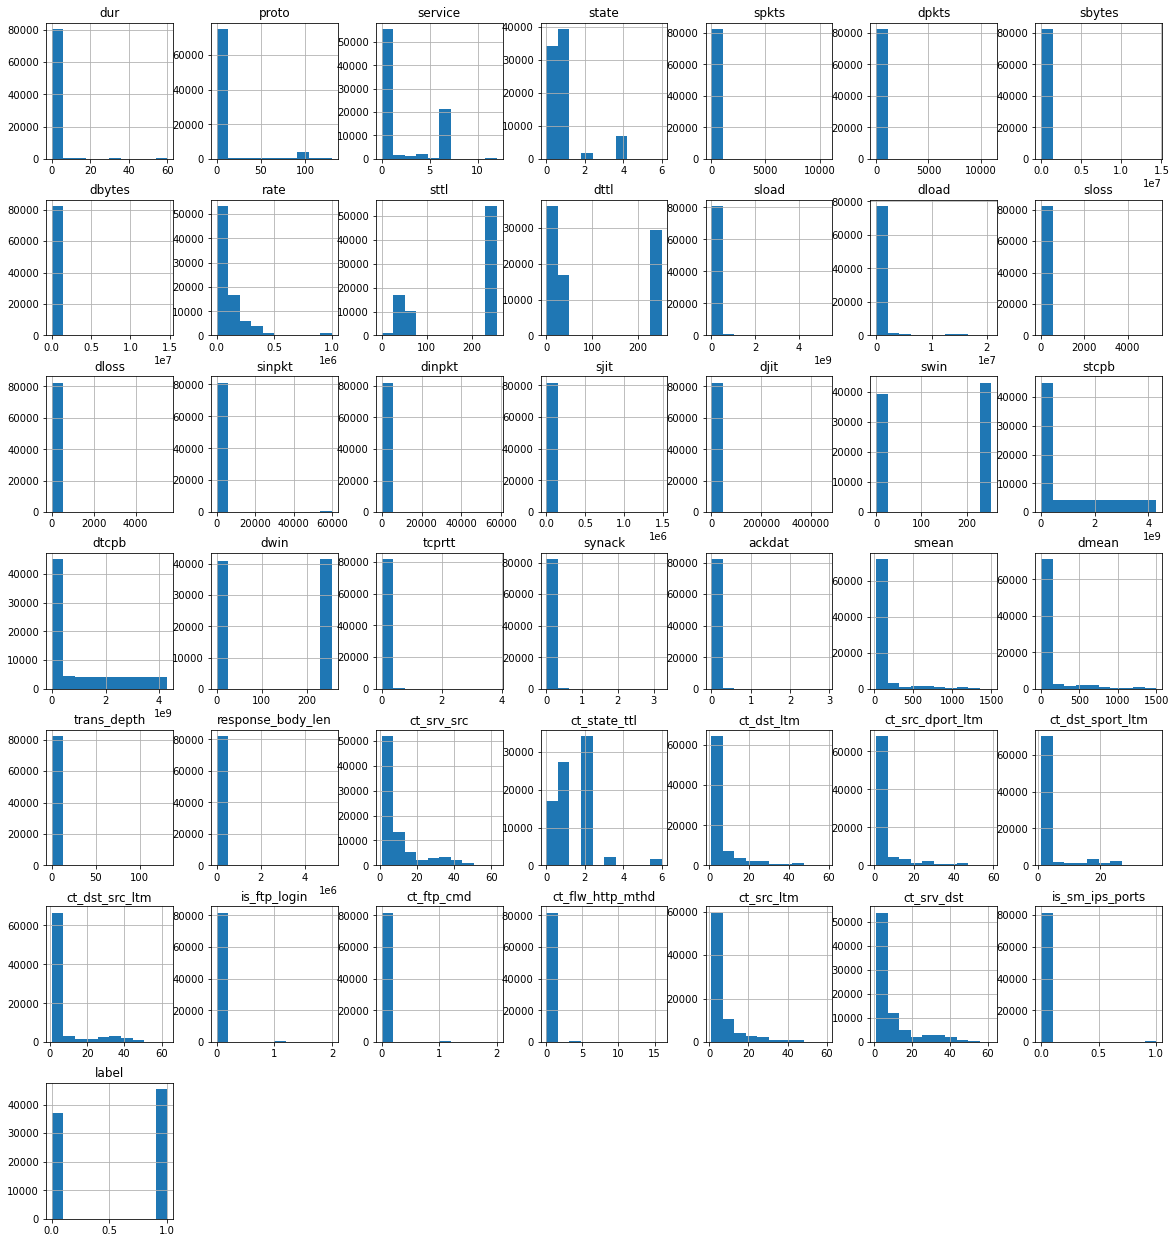

In [12]:
rcParams["figure.figsize"]=(20,22)
train_df.hist()
plt.grid()

#### Check Coorelation between the features

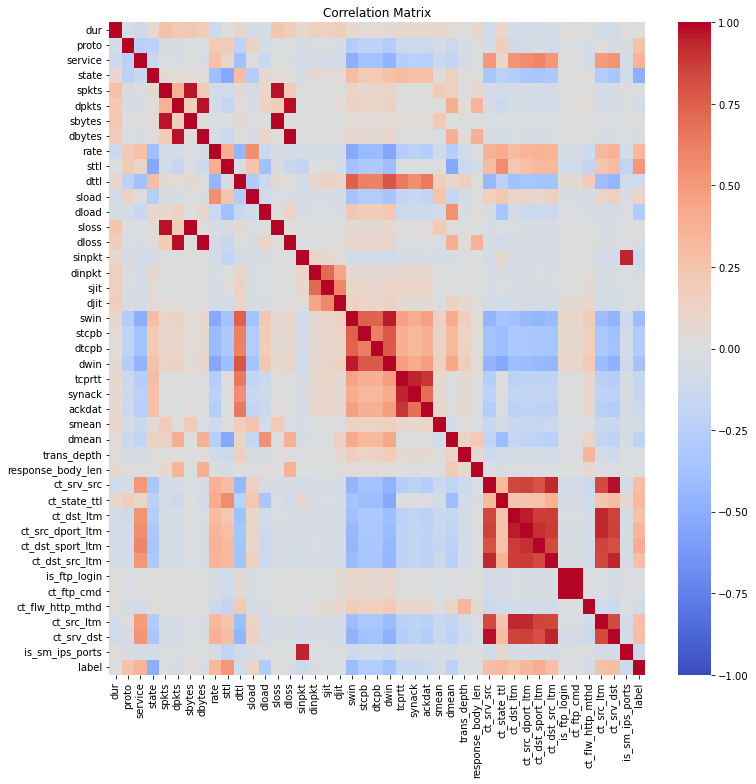

In [13]:
# Visualize - Correlation matrix

# Create a correlation matrix
corr_matrix = train_df.corr()

# Select the correlation values with 'label', label here means attack_cat
target_corr = corr_matrix['label']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

In [14]:
# Show the feature ranking in corr order 

# Calculate the absolute correlation values with the 'label'
target_corr_abs = corr_matrix['label'].abs()

# Sort the correlation values in descending order
sorted_corr = target_corr_abs.sort_values(ascending=False)

# Print the sorted correlation values and their corresponding attributes
for attribute, correlation in target_corr_abs.items():
    print(f"{attribute}: {correlation:.4f}")

dur: 0.0011
proto: 0.2592
service: 0.3568
state: 0.4993
spkts: 0.0277
dpkts: 0.0615
sbytes: 0.0206
dbytes: 0.0326
rate: 0.3286
sttl: 0.5042
dttl: 0.0986
sload: 0.1245
dload: 0.2805
sloss: 0.0064
dloss: 0.0444
sinpkt: 0.1208
dinpkt: 0.0376
sjit: 0.0274
djit: 0.0271
swin: 0.4145
stcpb: 0.2814
dtcpb: 0.2829
dwin: 0.3693
tcprtt: 0.1488
synack: 0.1499
ackdat: 0.1205
smean: 0.0611
dmean: 0.2115
trans_depth: 0.0258
response_body_len: 0.0164
ct_srv_src: 0.2902
ct_state_ttl: 0.3185
ct_dst_ltm: 0.2580
ct_src_dport_ltm: 0.3415
ct_dst_sport_ltm: 0.3937
ct_dst_src_ltm: 0.2800
is_ftp_login: 0.0162
ct_ftp_cmd: 0.0171
ct_flw_http_mthd: 0.0750
ct_src_ltm: 0.2765
ct_srv_dst: 0.2929
is_sm_ips_ports: 0.1174
label: 1.0000


# Prepare the data

### Convert Pandas DF to Spark DF

In [15]:
sparktrain_df = spark.createDataFrame(train_df)
sparktest_df = spark.createDataFrame(test_df)

In [16]:
num_partitions = 8
train_df = sparktrain_df.repartition(num_partitions)
test_df = sparktest_df.repartition(num_partitions)

### Feature enabler

##### for Default

In [17]:
pipeline = SparkDFPipeline(standardize=True)
train, test = pipeline.transform(train_df, test_df)

24/04/06 17:16:37 WARN TaskSetManager: Stage 1 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
24/04/06 17:18:43 WARN TaskSetManager: Stage 7 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


# Model selection and training
- Select machine learning models (Logistic Regression , Decision Tree, Sector-Vector Machine, Multilayer perceptron).
- Train the selected models using the training data.

## Logistic Regression model

### Default Model

In [18]:
# for default model
lr_default = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
pipeline_default = Pipeline(stages=[lr_default])
model_default = pipeline_default.fit(train)  # Use the 'train' dataset

24/04/06 17:19:08 WARN TaskSetManager: Stage 13 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
24/04/06 17:19:19 WARN TaskSetManager: Stage 14 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
24/04/06 17:27:36 WARN TaskSetManager: Stage 51 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
24/04/06 17:28:19 WARN TaskSetManager: Stage 52 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


###  Fine-Tuning 

#### Best Tuned Model

In [19]:
# Create a pipeline with the defined stages
pipeline = Pipeline(stages=[lr_default])

# Define the ParamGrid
paramGrid = ParamGridBuilder() \
    .addGrid(lr_default.maxIter, [10, 20, 30]) \
    .addGrid(lr_default.regParam, [0.1, 0.01]) \
    .build()

# Set up the appropriate evaluator based on process_label
if process_label == 'Multi':
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
elif process_label == 'Binary':
    evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")

# Instantiate CrossValidator with the pipeline and paramGrid
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Fit the CrossValidator on your training data
best_tuned_LR_model = cv.fit(train).bestModel

24/04/06 17:28:33 WARN TaskSetManager: Stage 53 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


#### Weight Model

In [20]:
# Train weighted model by calling train_weighted_logistic_regression function
weighted_lr_model = train_weighted_logistic_regression(train)

### Evaluation

In [21]:
# Evaluate models using the evaluate_model function
evaluation_results_LR_default = evaluate_model(model_default, test, 'Default Model',process_label)  # Use the 'test' dataset
evaluation_results_best_LR_tuned = evaluate_model(best_tuned_LR_model, test, 'Best-Tuned Model', process_label)  # Use the 'FT_test' dataset
evaluation_results_weighted = evaluate_model(weighted_lr_model, test, 'Weighted Model', process_label)  # Use the 'FT_test' dataset

# Print evaluation results for all models side by side
print("Evaluation Results:")
print(f"{'Metric':<20}{'Default Model':<20}{'Best-Tuned Model':<20}{'Weighted Model':<20}")
print("=" * 80)

for metric in evaluation_results_LR_default.keys():
    default_value = evaluation_results_LR_default[metric]
    best_tuned_value = evaluation_results_best_LR_tuned[metric]
    weighted_value = evaluation_results_weighted[metric]
    print(f"{metric:<20}{default_value:<20.6f}{best_tuned_value:<20.6f}{weighted_value:<20.6f}")


## SVM Model

### Default Model

In [22]:
# Train an SVM model
svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=100) 
svm_model = svm.fit(train)

###  Fine-Tuning 

In [23]:
svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=100)

# Define the parameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(svm.tol, [1e-4, 1e-5]) \
    .build()

# Define the evaluator for model selection
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")

# Create CrossValidator
cross_val = CrossValidator(estimator=svm,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=5)  # Number of folds for cross-validation

# Fit CrossValidator on train data
cv_model = cross_val.fit(train)

# Get the best LinearSVC model from the cross-validation
best_svm_model = cv_model.bestModel

### Evaluation

In [24]:
# Evaluate models using the evaluate_model function
evaluation_results_svm = evaluate_model(svm_model, test, 'SVM Model', process_label)
evaluation_results_best_svm = evaluate_model(best_svm_model, test, 'Best SVM Model', process_label)

print("Evaluation Results:")
print(f"{'Metric':<20}{'SVM Model':<20}{'Best SVM Model':<20}") 
print("=" * 60)

for metric, svm_value in evaluation_results_svm.items():
    best_svm_value = evaluation_results_best_svm[metric]
    print(f"{metric:<20}{svm_value:<20.6f}{best_svm_value:<20.6f}")

## Random Forest Model

### Default Model

In [ ]:
# Train a RandomForest model
default_rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)

# Create a pipeline
default_pipeline = Pipeline(stages=[default_rf])

# Train the pipeline
default_model = default_pipeline.fit(train)

# Make predictions on the test data
default_predictions = default_model.transform(test)


###  Fine-Tuning 

In [ ]:
# pipeline = SparkDFPipeline(standardize=True)
# FT_train, FT_test = pipeline.transform(train_df, test_df)

# Train a RandomForest model
tuned_rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)
if process_label == 'Multi':
    tuned_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
elif process_label == 'Binary':
    tuned_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")


# Define the parameter grid
param_grid = ParamGridBuilder() \
            .addGrid(tuned_rf.numTrees, [10,20,30]) \
            .addGrid(tuned_rf.maxDepth, [5,6,8]) \
            .addGrid(tuned_rf.impurity, ['gini']) \
            .build()

# Create a CrossValidator instance                                                                                                                                                                      
crossval = CrossValidator(estimator=tuned_rf,
                          estimatorParamMaps=param_grid,
                          evaluator=tuned_evaluator,
                          numFolds=3)  # Number of cross-validation folds

# Run cross-validation, and choose the best set of parameters
cv_model = crossval.fit(train)
best_model = cv_model.bestModel

# Get the best parameters
best_numTrees = best_model.getOrDefault('numTrees')
best_maxDepth = best_model.getOrDefault('maxDepth')
best_impurity = best_model.getOrDefault('impurity')

# Print the best parameters
print("Best numTrees:", best_numTrees)
print("Best maxDepth:", best_maxDepth)
print("Best impurity:", best_impurity)

# Make predictions on the test data
best_predictions = best_model.transform(test)

### Evaluation

In [ ]:
# Evaluate models using the evaluate_model function
evaluation_results_RF_default = evaluate_model(default_model, test, 'Default Model', process_label)  # Use the 'test' dataset

evaluation_results_tuned = evaluate_model(best_model, test, 'Fine-Tuned Model',process_label)  # Use the 'test' dataset


# Print evaluation results for both models side by side

print("Evaluation Results:")
print(f"{'Metric':<20}{'Default Model':<20}{'Fine-Tuned Model':<20}")
print("=" * 60)

for metric in evaluation_results_RF_default.keys():
    default_value = evaluation_results_RF_default[metric]
    tuned_value = evaluation_results_tuned[metric]
    print(f"{metric:<20}{default_value:<20.6f}{tuned_value:<20.6f}")

## Multilayer perceptron Model

### Model

In [ ]:
input_length = len(train.select('features').collect()[0][0])
output_length = train.select('label').distinct().count()

mlp = MultilayerPerceptronClassifier(seed=42, maxIter=100, stepSize=0.001)
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

# For binary classification
paramGrid1 = ParamGridBuilder() \
             .addGrid(mlp.layers, [
                    [input_length, 16, 16, 16, output_length],
                    [input_length, 32, 25, output_length],
             ]) \
             .build()

# For multi-class classification
paramGrid2 = ParamGridBuilder() \
             .addGrid(mlp.layers, [
                    [input_length, 26, 17, output_length],
                    [input_length, 27, 14, output_length],
                 # Add more layer combinations as needed
             ]) \
             .build()

if process_label == 'Binary':
       crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid1,
                          evaluator=evaluator,
                          numFolds=3) 
else:
       crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid2,
                          evaluator=evaluator,
                          numFolds=3) 

cv_model = crossval.fit(train)
ANN_best_model = cv_model.bestModel
best_params = ANN_best_model.extractParamMap()

In [ ]:
# Show the best parameters for the model
param_list = [(param.name, value) for param, value in best_params.items()]
shortened_output = "\n".join([f"{param}: {value}" for param, value in param_list])
print(shortened_output)

### Evaluation

In [ ]:
# Model evaluation
evaluation_results_ANN = evaluate_model(ANN_best_model, test, 'ANN Model', process_label)

print("Evaluation Results:")
print(f"{'Metric':<20}{'ANN Model':<20}")
print("=" * 60)

for metric in evaluation_results_ANN.keys():
    default_value = evaluation_results_ANN[metric]
    print(f"{metric:<20}{default_value:<20.6f}")